<a href="https://colab.research.google.com/github/svishakan/FYP-2021-22/blob/main/Models/News_Classifier_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install transformers
!pip install tensorflow_text

In [1]:
import tensorflow as tf
import pandas as pd
import transformers
import tensorflow_hub as hub
import tensorflow_text as text
import numpy as np

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
#df = pd.read_csv("../Datasets/newsdata.csv", names = ["Category", "Text"])
df = pd.read_csv("/content/drive/My Drive/FYP/newsdata.csv", names = ["Category", "Text"])
df.head()

,Category,Text
0,Crypto,Would You Shop at Tesla Using Dogecoin?
1,Crypto,Conmen made $1.3 bn via romance scams in 5 yea...
2,Crypto,Bitcoin paradise? Briton creates crypto utopia...
3,Crypto,Intel Launches Blockchain Chip To Tap Crypto Boom
4,Crypto,OpenSea's NFT Free-for-All


In [4]:
from sklearn.utils import shuffle
df = shuffle(df)
df.head()

,Category,Text
14,Crypto,What are meme coins? From Shiba Inu to Dogecoin
97,Tech,Get a Kindle for under 40 with this incredible...
105,Tech,Samsung Galaxy S22 Ultra 6 reasons to buy and...
46,EVs,Tata Nexon Midsize SUV Coupe To Use Powerful P...
81,Gaming,"UFC 271 Embedded, part 4 - Practice and patience"


In [5]:
df.Category.unique()

array(['Crypto', 'Tech', 'EVs', 'Gaming', 'Oil'], dtype=object)

In [6]:
df["Category"] = df["Category"].replace({'Crypto': 0, 'Oil': 1, 'EVs': 2, 'Tech': 3, 'Gaming': 4})

#Category-wise data point counts
df["Category"].value_counts()

3    33
4    27
0    19
1    19
2    18
Name: Category, dtype: int64

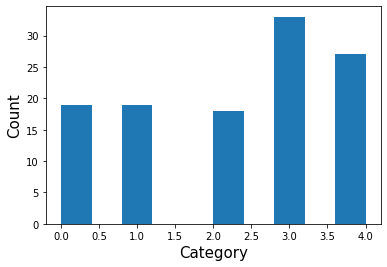

In [7]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.set_xlabel('Category', fontsize=15)
ax.set_ylabel('Count', fontsize=15)

df.Category.hist(ax=ax,grid=False, bins= 10)
plt.show()

In [8]:
e_df = df

In [9]:
from sklearn.model_selection import train_test_split

x_train, x_test = train_test_split(e_df, 
                                   random_state = 0,
                                   test_size = 0.2)

In [10]:
from transformers import BertTokenizer, TFBertForSequenceClassification
from transformers import InputExample, InputFeatures

In [11]:
def convert_data(train, test, DATA_COL, LABEL_COL):
    
    train_input = train.apply(lambda x: InputExample(guid = None,
                                                    text_a = x[DATA_COL],
                                                    text_b = None,
                                                    label = x[LABEL_COL],
                                                    ), axis = 1)
    
    test_input = test.apply(lambda x: InputExample(guid = None,
                                                   text_a = x[DATA_COL],
                                                   text_b = None,
                                                   label = x[LABEL_COL],
                                                   ), axis = 1)
    
    return train_input, test_input

In [12]:
def convert_to_tf_dataset(input_data, tokenizer, max_length = 200):
    features = []
    
    for i in input_data:
        input_dict = tokenizer.encode_plus(
            i.text_a,
            add_special_tokens = True,
            max_length = max_length,
            return_token_type_ids = True,
            return_attention_mask = True,
            pad_to_max_length = True,
            truncation = True
        )
        
        input_ids, token_type_ids, attention_mask = (
            input_dict["input_ids"],
            input_dict["token_type_ids"],
            input_dict["attention_mask"]
        )
        
        features.append(InputFeatures(
            input_ids = input_ids, attention_mask = attention_mask,
            token_type_ids = token_type_ids, label = i.label))
        
    
    def gen():
        for f in features:
            yield({
                "input_ids": f.input_ids,
                "attention_mask": f.attention_mask,
                "token_type_ids": f.token_type_ids
            }, f.label)
            
    
    return tf.data.Dataset.from_generator(
        gen, ({"input_ids": tf.int32, "attention_mask": tf.int32,
              "token_type_ids": tf.int32}, tf.int64),
            ({
                "input_ids": tf.TensorShape([None]),
                "attention_mask": tf.TensorShape([None]),
                "token_type_ids": tf.TensorShape([None])
            },
                tf.TensorShape([]), 
            ),)

DATA_COL = "Text"
LABEL_COL = "Category"

In [13]:
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [14]:
train, test = convert_data(x_train, x_test, DATA_COL, LABEL_COL)

In [15]:
train_data = convert_to_tf_dataset(list(train), tokenizer)
train_data = train_data.shuffle(100).batch(32).repeat(2)

test_data = convert_to_tf_dataset(list(test), tokenizer).batch(32)

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2257: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [16]:
model = TFBertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=5)
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
model.summary()

Downloading:   0%|          | 0.00/511M [00:00<?, ?B/s]

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model: "tf_bert_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  109482240 
                                                                 
 dropout_37 (Dropout)        multiple                  0         
                                                                 
 classifier (Dense)          multiple                  3845      
                                                                 
Total params: 109,486,085
Trainable params: 109,486,085
Non-trainable params: 0
_________________________________________________________________


In [17]:
model_metrics = [
    tf.keras.metrics.SparseCategoricalAccuracy(name = "accuracy")
]

model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=3e-5, epsilon=1e-08, clipnorm=1.0), 
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics = model_metrics)

history = model.fit(train_data, epochs = 10)

Epoch 1/10
6/6 [==============================] - 29s 1s/step - loss: 1.5863 - accuracy: 0.2391
Epoch 2/10
6/6 [==============================] - 7s 1s/step - loss: 1.4687 - accuracy: 0.4076
Epoch 3/10
6/6 [==============================] - 7s 1s/step - loss: 1.3311 - accuracy: 0.5652
Epoch 4/10
6/6 [==============================] - 7s 1s/step - loss: 1.1800 - accuracy: 0.6685
Epoch 5/10
6/6 [==============================] - 7s 1s/step - loss: 0.9594 - accuracy: 0.8152
Epoch 6/10
6/6 [==============================] - 7s 1s/step - loss: 0.7408 - accuracy: 0.8804
Epoch 7/10
6/6 [==============================] - 7s 1s/step - loss: 0.5645 - accuracy: 0.9076
Epoch 8/10
6/6 [==============================] - 7s 1s/step - loss: 0.4167 - accuracy: 0.9728
Epoch 9/10
6/6 [==============================] - 7s 1s/step - loss: 0.2874 - accuracy: 0.9946
Epoch 10/10
6/6 [==============================] - 7s 1s/step - loss: 0.1988 - accuracy: 0.9891


In [18]:
model.summary()

Model: "tf_bert_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  109482240 
                                                                 
 dropout_37 (Dropout)        multiple                  0         
                                                                 
 classifier (Dense)          multiple                  3845      
                                                                 
Total params: 109,486,085
Trainable params: 109,486,085
Non-trainable params: 0
_________________________________________________________________


In [19]:
y_pred = model.predict(test_data)

In [20]:
y_pred_argmax = np.argmax(y_pred[0], axis = 1)

In [21]:
y_true = x_test["Category"]

Text(33.0, 0.5, 'Ground Truth')

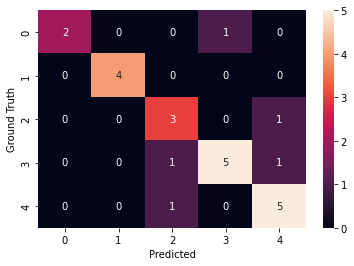

In [22]:
from sklearn.metrics import confusion_matrix, classification_report

cm = confusion_matrix(y_true, y_pred_argmax)

import matplotlib.pyplot as plt
import seaborn as sns

sns.heatmap(cm, annot = True)
plt.xlabel("Predicted")
plt.ylabel("Ground Truth")

In [23]:
print(classification_report(y_true, y_pred_argmax))

              precision    recall  f1-score   support

           0       1.00      0.67      0.80         3
           1       1.00      1.00      1.00         4
           2       0.60      0.75      0.67         4
           3       0.83      0.71      0.77         7
           4       0.71      0.83      0.77         6

    accuracy                           0.79        24
   macro avg       0.83      0.79      0.80        24
weighted avg       0.81      0.79      0.79        24

